# 06 - Causal Inference (CausalML)

This notebook implements the **second phase** requested in the assignment using CausalML with the same CLV dataset.

- **Target / outcome:** `log1p(CLV)`
- **Treatment:** synthetic campaign exposure (`TreatmentGroup`: `campaign` vs `control`)
- **Control features:** RFM + behavioral features
- **Models:** `LRSRegressor`, `XGBTRegressor`
- **Explainability:** causal feature importance + uplift distribution

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path('..').resolve()
sys.path.append(str(ROOT / 'src'))

from causal import CAUSALML_AVAILABLE, create_campaign_treatment, run_causal_analysis

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
print('CausalML available:', CAUSALML_AVAILABLE)

CausalML available: True


/Users/othmanezizi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Feature Dataset
The project pipeline creates `data/processed/customer_features.csv` in the previous phase.

In [2]:
feature_path = ROOT / 'data' / 'processed' / 'customer_features.csv'
df = pd.read_csv(feature_path)
print('Shape:', df.shape)
df.head()

Shape: (4266, 10)


,Customer ID,Recency,Frequency,Monetary,Tenure,AvgTimeBetweenPurchases,NumUniqueProducts,AvgBasketSize,AvgOrderValue,CLV
0,12346,155,11,372.86,351,6.000000,26,6.363636,33.896364,77183.60
1,12347,30,1,611.53,30,0.000000,40,509.000000,611.530000,2535.22
2,12348,64,1,222.16,64,0.000000,20,373.000000,222.160000,1487.24
3,12349,33,3,2671.14,215,1.782178,90,331.000000,890.380000,0.00
4,12351,1,1,300.93,1,0.000000,21,261.000000,300.930000,0.00


## 2. Define Outcome, Treatment, and Controls

We construct a realistic campaign assignment policy to emulate observational treatment assignment.
This lets us estimate heterogenous treatment effects in a CLV setting.

In [3]:
feature_cols = [
    'Recency', 'Frequency', 'Monetary', 'Tenure',
    'AvgTimeBetweenPurchases', 'NumUniqueProducts',
    'AvgBasketSize', 'AvgOrderValue'
]

df_causal = create_campaign_treatment(df, random_state=42)
df_causal['OutcomeLog1p'] = np.log1p(df_causal['CLV'])

print('Treatment split:')
print(df_causal['TreatmentGroup'].value_counts(normalize=True).round(3))
df_causal[['CLV', 'OutcomeLog1p', 'TreatmentGroup', 'PropensityScore']].head()

Treatment split:
TreatmentGroup
campaign    0.508
control     0.492
Name: proportion, dtype: float64


,CLV,OutcomeLog1p,TreatmentGroup,PropensityScore
0,77183.60,11.253955,campaign,0.560756
1,2535.22,7.838430,control,0.397585
2,1487.24,7.305349,campaign,0.679833
3,0.00,0.000000,control,0.481925
4,0.00,0.000000,control,0.266581


## 3. Run CausalML Regressors
Required models: **LRSRegressor** and **XGBTRegressor**.

In [4]:
if not CAUSALML_AVAILABLE:
    raise ImportError('CausalML is not available in this environment. Install causalml and rerun.')

reports_dir = ROOT / 'reports'
results = run_causal_analysis(
    df=df_causal,
    feature_cols=feature_cols,
    outcome_col='CLV',
    output_dir=reports_dir,
    control_name='control',
    random_state=42,
)

results.ate_results

,Model,ATE_log1p,ATE_CI_lower,ATE_CI_upper
0,LRSRegressor,-0.178501,-0.378294,0.021292
1,XGBTRegressor,-0.167256,-0.257540,-0.076973


## 4. Treatment Effect and Feature Importance

Top causal features:


,Feature,Importance_LRSRegressor,Importance_XGBTRegressor,Importance_Avg
1,Frequency,0.072851,0.268054,0.170452
2,Monetary,0.000005,0.221720,0.110863
3,Tenure,0.007229,0.092665,0.049947
4,AvgTimeBetweenPurchases,0.011023,0.088577,0.049800
7,AvgOrderValue,0.000628,0.092096,0.046362
5,NumUniqueProducts,0.002564,0.082998,0.042781
6,AvgBasketSize,0.000103,0.085208,0.042656
0,Recency,0.011963,0.068683,0.040323


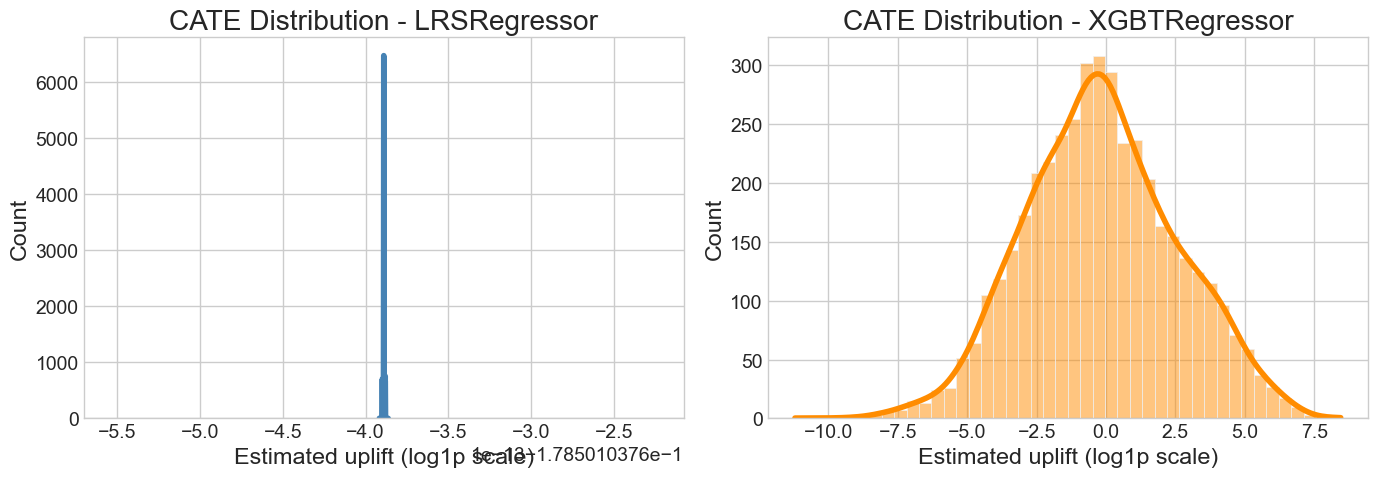

In [5]:
print('Top causal features:')
display(results.feature_importance.head(10))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(results.uplift_predictions['CATE_LRSRegressor'], kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('CATE Distribution - LRSRegressor')
axes[0].set_xlabel('Estimated uplift (log1p scale)')

sns.histplot(results.uplift_predictions['CATE_XGBTRegressor'], kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('CATE Distribution - XGBTRegressor')
axes[1].set_xlabel('Estimated uplift (log1p scale)')

plt.tight_layout()
plt.show()

## 5. Interpretation

- Compare the ATE confidence intervals from both models to check directional consistency.
- Use top CATE customers for treatment targeting in campaign policy.
- Use causal feature importance to understand which customer behaviors drive treatment response.
- Validate against business constraints before deploying targeting rules.